# Introduction

Based on the result using meta data on the small dataset, it seems that it's the best approach we have so far. This dataset was quite simple with 8 classes and 7994 observations. To avoid overfitting, we applied PCA and got 90+% of accuracy. 

In this notebook, the objectif will be to do it on the complete dataset. There will be more complexe things because classes will be unbalanced and some audio may have multiple main classes. Based on the result, we may train additionnal model to sub classify audio.

In [16]:
import pandas as pd
import numpy as np
import itertools

from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

pd.set_option('max_info_columns', 999)
pd.options.display.max_rows = 200

%matplotlib inline

In [17]:
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.models import Model
from keras import backend as K
from keras.utils.generic_utils import get_custom_objects
from keras.layers import Activation
from keras.utils.np_utils import to_categorical

C:\python36\envs\machine_learning\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [1]:
def clean_classes(x):
    if len(x) == 0:
        return "-1"
    elif "," in x:
        list_genre = x.split(",")
        new_genres = set(naming[converter[int(c)]] for c in list_genre)
        return ",".join(list(new_genres))
    else:
        return naming[converter[int(x)]]

# Preparation of data

## Loading Features

In [11]:
features = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                               ...      tonnetz  \
statistics                                            ...          std   
number            07        08        09        10    ...           04   
track_id                                              ...                
2           1.481593  2.691455  0.866868  1.341231    ...     0.054125   
3           1.366848  1.054094  0.108103  0.619185    ...     0.063831   
5          -0.923192 -0.927232  0.666617  1.038546    ...     0.040730   
10          1.770694  1.604566  0.521217  1.982386    ...     0.074358   
20         -0.289294 -0.816410  0.043851 -0.804761    ...     0.095003   

feature                               zcr                                \
statistics                       kurtosis       max      mean    median   
number            05        06         01        01        01        01   
track_id                                                                  
2           0.012226  0.012111   5.758890  0.459473  0.085629  0.071289   
3           0.014212  0.017740   2.824694  0.466309  0.084578  0.063965   
5           0.012691  0.014759   6.808415  0.375000  0.053114  0.041504   
10          0.017952  0.013921  21.434212  0.452148  0.077515  0.071777   
20          0.022492  0.021355  16.669037  0.469727  0.047225  0.040039   

feature                                   
statistics       min      skew       std  
number            01        01        01  
track_id                                  
2           0.000000  2.089872  0.061448  
3           0.000000  1.716724  0.069330  
5           0.000000  2.193303  0.044861  
10          0.000000  3.542325  0.040800  
20          0.000977  3.189831  0.030993  

[5 rows x 518 columns]

In [12]:
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 106574 entries, 2 to 155320
Data columns (total 518 columns):
(chroma_cens, kurtosis, 01)           106574 non-null float64
(chroma_cens, kurtosis, 02)           106574 non-null float64
(chroma_cens, kurtosis, 03)           106574 non-null float64
(chroma_cens, kurtosis, 04)           106574 non-null float64
(chroma_cens, kurtosis, 05)           106574 non-null float64
(chroma_cens, kurtosis, 06)           106574 non-null float64
(chroma_cens, kurtosis, 07)           106574 non-null float64
(chroma_cens, kurtosis, 08)           106574 non-null float64
(chroma_cens, kurtosis, 09)           106574 non-null float64
(chroma_cens, kurtosis, 10)           106574 non-null float64
(chroma_cens, kurtosis, 11)           106574 non-null float64
(chroma_cens, kurtosis, 12)           106574 non-null float64
(chroma_cens, max, 01)                106574 non-null float64
(chroma_cens, max, 02)                106574 non-null float64
(chroma_cens, max, 0

## Loading genres

In [21]:
genres = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/genres.csv", index_col=0)
genres.head()

,#tracks,parent,title,top_level
genre_id,,,,
1,8693,38,Avant-Garde,38
2,5271,0,International,2
3,1752,0,Blues,3
4,4126,0,Jazz,4
5,4106,0,Classical,5


## Loading genres

In [14]:
tracks = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/tracks.csv", 
                     header=[0, 1], 
                     skipinitialspace=True, 
                     index_col=0)
tracks = tracks[[("track", "genres_all"), ("track", "genres"), ("track", "genre_top")]]
tracks.columns = [col[1] for col in tracks.columns]
tracks.head()

,genres_all,genres,genre_top
track_id,,,
2,[21],[21],Hip-Hop
3,[21],[21],Hip-Hop
5,[21],[21],Hip-Hop
10,[10],[10],Pop
20,"[17, 10, 76, 103]","[76, 103]",NaN


First, we can see that in the full dataset we have a lot of missing top genres. This is due to 2 things :
    
- The audio doesn't have any genres
- The audio have multiple main genres

So now we will remove sample without genres and get all main genres for all other sample.

In [15]:
tracks[tracks["genre_top"].isnull()]

,genres_all,genres,genre_top
track_id,,,
20,"[17, 10, 76, 103]","[76, 103]",NaN
26,"[17, 10, 76, 103]","[76, 103]",NaN
30,"[17, 10, 76, 103]","[76, 103]",NaN
46,"[17, 10, 76, 103]","[76, 103]",NaN
48,"[17, 10, 76, 103]","[76, 103]",NaN
185,"[10, 27, 12, 76]","[27, 76]",NaN
236,"[2, 92, 15]","[15, 92]",NaN
246,"[10, 12, 76]","[12, 76]",NaN
248,"[10, 12, 76]","[12, 76]",NaN


In [16]:
converter = genres[["top_level"]].to_dict()["top_level"]
naming = genres[["title"]].to_dict()["title"]

tracks["clean_class"] = tracks['genres_all'].str.replace("[^0-9,]", "").apply(clean_classes)
tracks = tracks[tracks["clean_class"] != "-1"]

In [17]:
tracks.head()

,genres_all,genres,genre_top,clean_class
track_id,,,,
2,[21],[21],Hip-Hop,Hip-Hop
3,[21],[21],Hip-Hop,Hip-Hop
5,[21],[21],Hip-Hop,Hip-Hop
10,[10],[10],Pop,Pop
20,"[17, 10, 76, 103]","[76, 103]",NaN,"Folk,Pop"


In [18]:
tracks["clean_class"].value_counts()

Rock                                                                                         14182
Experimental                                                                                 10608
Electronic                                                                                    9372
Electronic,Experimental                                                                       6851
Hip-Hop                                                                                       3552
Rock,Experimental                                                                             3118
Rock,Pop                                                                                      3024
Folk                                                                                          2803
Instrumental,Electronic                                                                       2694
Pop                                                                                           2332
Instrument

Now all remaining tracks have at least 1 genre. The problem is that around 45% of songs have multiple genres like Pop + Rock. We cannot directly label them as is but we can use a BoW.

In [25]:
tracks_OHE = tracks["clean_class"].str.get_dummies(sep=',')

In [26]:
y = tracks_OHE.values

In [34]:
print("We now have {} observations and {} genres".format(*y.shape))
print("{:.02f}% of observation have more than 1 genre".format((y.sum(axis=1) > 1).mean()*100))
print("In average, a song has {:.02f} genres".format(y.sum(axis=1).mean()))
print("The balance of genre is :\n")
print(tracks_OHE.sum(axis=0))

We now have 104343 observations and 16 genres
52.47% of observation have more than 1 genre
In average, a song has 1.70 genres
The balance of genre is :

Blues                   1752
Classical               4106
Country                 1987
Easy Listening           730
Electronic             34413
Experimental           38154
Folk                   12706
Hip-Hop                 8389
Instrumental           14938
International           5271
Jazz                    4126
Old-Time / Historic      868
Pop                    13845
Rock                   32923
Soul-RnB                1499
Spoken                  1876
dtype: int64


The next step will require lot of memory so the best is to save this dataset, clean the memroy and restart from here

In [35]:
tracks_OHE.to_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/classes.csv")

# Balancing the dataset

## Dataset preparation

What we saw previously is that the dataset is very unbalanced. Unfortunately, there is no way to balance a BoW yet. So we will use a trick to do so. The idea is to duplicate features of audio having multiple genres, then keep only 1 genres for each. Then we can balance the dataset using classic solution of oversampling. A simpler visualisation is <img src="balancing.png"/>

To avoid memory issue, we will duplicate first only the genre dataset then join the feature based on the audio id.

In [36]:
classes = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/classes.csv")

In [37]:
to_merge = classes.columns[1:]
id_ = classes.columns[0]

In [38]:
temp = pd.melt(classes, id_vars = id_, value_vars = to_merge)
temp = temp[temp.value == 1]
temp = temp.drop("value", axis=1)
temp = temp.set_index("track_id")

In [40]:
temp.head()

,variable
track_id,
461,Blues
462,Blues
463,Blues
464,Blues
465,Blues


This is it, now we have 1.7 x 103k observation as we have an average of 1.7 genres per audio. The balance is still the same as shown previously. We can join features now and then balance the dataset

In [30]:
features = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/features.csv", header=[0, 1, 2], skipinitialspace=True, index_col=0)

In [42]:
temp.columns = [("y", "y", "y")]  # required to join 2 dataset of same number of level

In [43]:
features = features.join(temp)

C:\python36\envs\machine_learning\lib\site-packages\pandas\core\reshape\merge.py:551: UserWarning: merging between different levels can give an unintended result (3 levels on the left, 1 on the right)
  warnings.warn(msg, UserWarning)


In [44]:
features.head()

feature    chroma_cens                                                    \
statistics    kurtosis                                                     
number              01        02        03        04        05        06   
track_id                                                                   
2             7.180653  5.230309  0.249321  1.347620  1.482478  0.531371   
3             1.888963  0.760539  0.345297  2.295201  1.654031  0.067592   
5             0.527563 -0.077654 -0.279610  0.685883  1.937570  0.880839   
10            3.702245 -0.291193  2.196742 -0.234449  1.367364  0.998411   
20           -0.193837 -0.198527  0.201546  0.258556  0.775204  0.084794   

feature                                              ...      tonnetz  \
statistics                                           ...          std   
number            07        08        09        10   ...           05   
track_id                                             ...                
2           1.481593  2.691455  0.866868  1.341231   ...     0.012226   
3           1.366848  1.054094  0.108103  0.619185   ...     0.014212   
5          -0.923192 -0.927232  0.666617  1.038546   ...     0.012691   
10          1.770694  1.604566  0.521217  1.982386   ...     0.017952   
20         -0.289294 -0.816410  0.043851 -0.804761   ...     0.022492   

feature                     zcr                                          \
statistics             kurtosis       max      mean    median       min   
number            06         01        01        01        01        01   
track_id                                                                  
2           0.012111   5.758890  0.459473  0.085629  0.071289  0.000000   
3           0.017740   2.824694  0.466309  0.084578  0.063965  0.000000   
5           0.014759   6.808415  0.375000  0.053114  0.041504  0.000000   
10          0.013921  21.434212  0.452148  0.077515  0.071777  0.000000   
20          0.021355  16.669037  0.469727  0.047225  0.040039  0.000977   

feature                               y  
statistics      skew       std        y  
number            01        01        y  
track_id                                 
2           2.089872  0.061448  Hip-Hop  
3           1.716724  0.069330  Hip-Hop  
5           2.193303  0.044861  Hip-Hop  
10          3.542325  0.040800      Pop  
20          3.189831  0.030993     Folk  

[5 rows x 519 columns]

Due to the join, we have audio without class, we can remove them (maybe a innerjoin would have been more clever...)

In [45]:
features = features[~features[("y", "y", "y")].isnull()]

## Balancing

Now we have our dataset ready for the balance. What we can do upfront is to save both matrices (not dataset) and clean again the memory.

In [47]:
X = features.drop(("y", "y", "y"), axis=1).values
y = features[("y", "y", "y")].values

In [48]:
np.save("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/new_X.npy", X)
np.save("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/new_y.npy", y)

In [2]:
X = np.load("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/new_X.npy")
y = np.load("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/preprocessed_meta/new_y.npy")

In [3]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN 
ros = RandomOverSampler(random_state=0)
X, y = ros.fit_sample(X, y)

Now our dataset should be balanced. Let'(s apply a Label Bisarizer and count each class

In [4]:
enc = LabelBinarizer()
y = enc.fit_transform(y.reshape(-1, 1))

In [5]:
y.sum(axis=0)

array([38154, 38154, 38154, 38154, 38154, 38154, 38154, 38154, 38154,
       38154, 38154, 38154, 38154, 38154, 38154, 38154])

In [6]:
y.shape

(610464, 16)

We properly have the same number of classes and the same number of observations. We can now apply the same pre-processing as the previous notebbok but with 610464 observations, there is no need to apply a PCA to reduce dimensions

# Data preparation

In [7]:
X = MinMaxScaler().fit_transform(X)

An important thing to do also is to shuffle the dataset as it was sorted by class du to the melt and the RandomOverSampler. After that, the training will be done using a random split on the training set. But we will keep a validation set out.

In [8]:
X, y = shuffle(X, y, random_state=0)

In [9]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [10]:
del X
del y

# Model

In [12]:
K.clear_session()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               132864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
Total params: 150,352
Trainable params: 150,352
Non-trainable params: 0
_________________________________________________________________


In [13]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", "accuracy"])

In [14]:
history = model.fit(X_train, y_train, 
                      epochs=5, 
                      batch_size=1000, 
                      verbose=1, 
                      validation_split=0.2)

Train on 415115 samples, validate on 103779 samples
Epoch 1/5
415115/415115 [==============================] - 8s 20us/step - loss: 0.2142 - binary_crossentropy: 0.2142 - acc: 0.9391 - val_loss: 0.2018 - val_binary_crossentropy: 0.2018 - val_acc: 0.9401
Epoch 2/5
415115/415115 [==============================] - 5s 11us/step - loss: 0.1996 - binary_crossentropy: 0.1996 - acc: 0.9403 - val_loss: 0.1939 - val_binary_crossentropy: 0.1939 - val_acc: 0.9410
Epoch 3/5
415115/415115 [==============================] - 5s 12us/step - loss: 0.1945 - binary_crossentropy: 0.1945 - acc: 0.9408 - val_loss: 0.2054 - val_binary_crossentropy: 0.2054 - val_acc: 0.9386
Epoch 4/5
415115/415115 [==============================] - 5s 12us/step - loss: 0.1916 - binary_crossentropy: 0.1916 - acc: 0.9411 - val_loss: 0.1947 - val_binary_crossentropy: 0.1947 - val_acc: 0.9403
Epoch 5/5
415115/415115 [==============================] - 5s 11us/step - loss: 0.1887 - binary_crossentropy: 0.1887 - acc: 0.9414 - val_los

# Result

Stability is reach quite fast. we can now evaluate it on the validation set.

In [15]:
y_pred = model.predict(X_val, batch_size=500)

In [17]:
# just to clear memory

K.clear_session()
del X_train
del y_train

In [30]:
y_pred[10, :]

array([0.0094475 , 0.00596818, 0.0035816 , 0.03833479, 0.19119968,
       0.03631313, 0.01211707, 0.24684896, 0.04468754, 0.17373377,
       0.01787476, 0.00033049, 0.04899017, 0.0214127 , 0.12618962,
       0.02297008], dtype=float32)

First if we look at prediction, we can see that there is no clear prediction, that starts bad... Let's look at the Confusion matrix

In [32]:
y_ohe = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

In [45]:
y_pred_classe = enc.inverse_transform(y_ohe)
y_val_classe = enc.inverse_transform(y_val)

Confusion matrix, without normalization


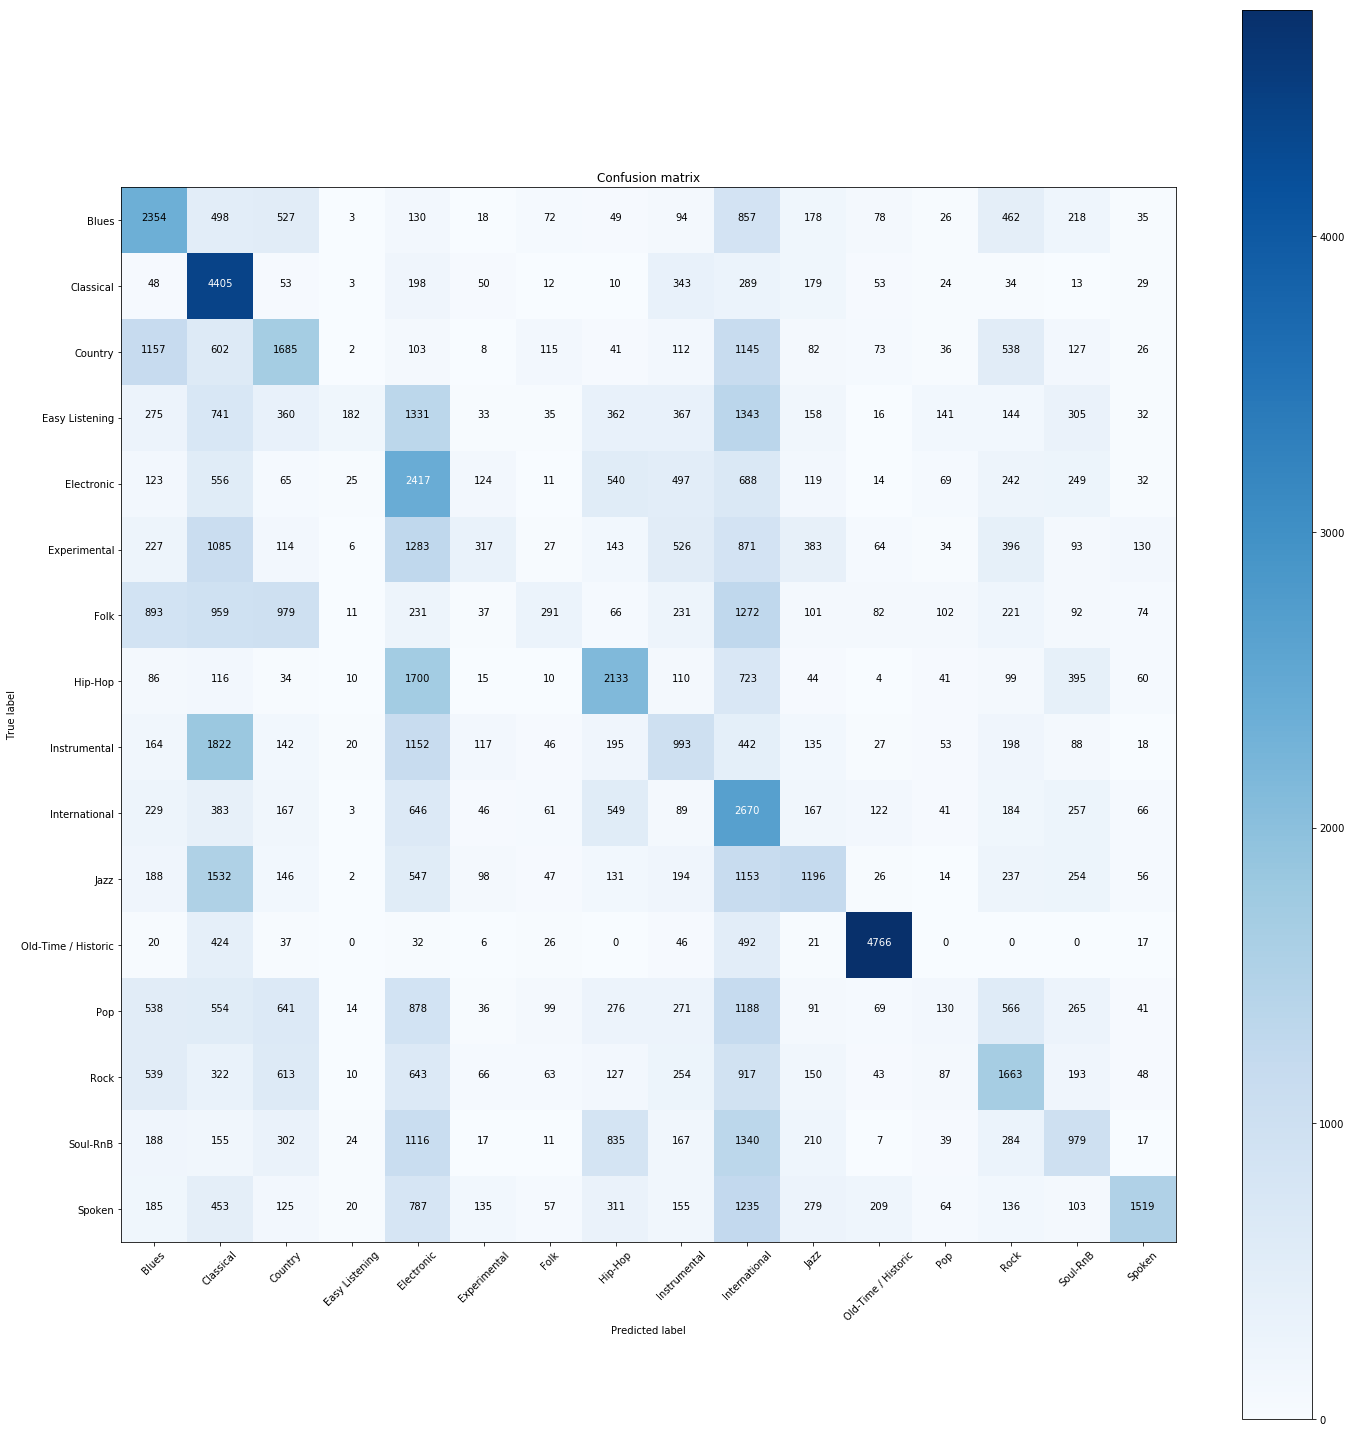

In [55]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
cnf_matrix = confusion_matrix(y_val_classe, y_pred_classe)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(20,20))
plot_confusion_matrix(cnf_matrix, classes=enc.classes_)
plt.show()

Strange for a prediction of 94%. Let's look at the accuracy on validation set manually

In [53]:
accuracy_score(y_val, y_ohe)

0.30250081904553894

# Analysis

Suprise... only 30%. Why the result is so low? My guess is due to the oversampling method. I was expecting the model to minimize the loss and prediction for example 50%/50% as 1 observation can be either one or the other. but with the oversampling, we introduce a lot of noise as a small variation of a Pop Rock song can be Rock only for example. This is clearly not a good solution.

Before to Finish, let's just try the model on unbalanced dataset. maybe the result will be better

In [6]:
features = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/features.csv", 
                       header=[0, 1, 2], skipinitialspace=True, index_col=0)
classes = pd.read_csv("F:/Nicolas/DNUPycharmProjects/machine_learning/audio/FMA/fma_metadata/classes.csv", index_col=0)

In [9]:
features = features[features.index.isin(classes.index)]

In [10]:
X = features.values
y = classes.values

In [13]:
X = MinMaxScaler().fit_transform(X)

In [14]:
X, y = shuffle(X, y, random_state=0)

In [15]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.15, random_state=42)

In [18]:
K.clear_session()

model = Sequential()
model.add(Dense(256, input_dim=X_train.shape[1], activation='elu'))
model.add(Dropout(0.4))
model.add(Dense(64, activation='elu'))
model.add(Dropout(0.2))
model.add(Dense(16, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               132864    
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                16448     
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                1040      
Total params: 150,352
Trainable params: 150,352
Non-trainable params: 0
_________________________________________________________________


In [19]:
model.compile(loss='binary_crossentropy', 
              optimizer='Nadam', 
              metrics=["binary_crossentropy", "accuracy"])

In [21]:
history = model.fit(X_train, y_train, 
                      epochs=25, 
                      batch_size=1000, 
                      verbose=1, 
                      validation_split=0.2)

Train on 70952 samples, validate on 17739 samples
Epoch 1/25
70952/70952 [==============================] - 1s 11us/step - loss: 0.2626 - binary_crossentropy: 0.2626 - acc: 0.8973 - val_loss: 0.2527 - val_binary_crossentropy: 0.2527 - val_acc: 0.8965
Epoch 2/25
70952/70952 [==============================] - 1s 11us/step - loss: 0.2594 - binary_crossentropy: 0.2594 - acc: 0.8980 - val_loss: 0.2523 - val_binary_crossentropy: 0.2523 - val_acc: 0.8996
Epoch 3/25
70952/70952 [==============================] - 1s 11us/step - loss: 0.2584 - binary_crossentropy: 0.2584 - acc: 0.8982 - val_loss: 0.2487 - val_binary_crossentropy: 0.2487 - val_acc: 0.9000
Epoch 4/25
70952/70952 [==============================] - 1s 11us/step - loss: 0.2561 - binary_crossentropy: 0.2561 - acc: 0.8989 - val_loss: 0.2489 - val_binary_crossentropy: 0.2489 - val_acc: 0.8991
Epoch 5/25
70952/70952 [==============================] - 1s 11us/step - loss: 0.2543 - binary_crossentropy: 0.2543 - acc: 0.8994 - val_loss: 0.24

In [22]:
y_pred = model.predict(X_val, batch_size=500)

In [23]:
K.clear_session()
del X_train
del y_train

In [24]:
y_pred[10, :]

array([1.6993685e-02, 4.4145552e-03, 3.2401435e-02, 2.9894384e-03,
       7.4777277e-03, 6.7571200e-02, 6.5861233e-02, 1.1246969e-03,
       1.0620688e-02, 3.3953063e-02, 4.9277544e-02, 7.3500560e-05,
       5.6307834e-02, 6.4064819e-01, 8.4297983e-03, 1.8553571e-03],
      dtype=float32)

In [25]:
y_ohe = (y_pred == y_pred.max(axis=1)[:,None]).astype(int)

In [26]:
accuracy_score(y_val, y_ohe)

0.2862892921032456

Only 28% ... still low but we should keep in mind that we may predict multiclass so we should consider as true all class for example above 0.3

In [44]:
y_ohe2 = (y_pred>0.32).astype(int)
accuracy_score(y_val, y_ohe2)

0.22961921799131102

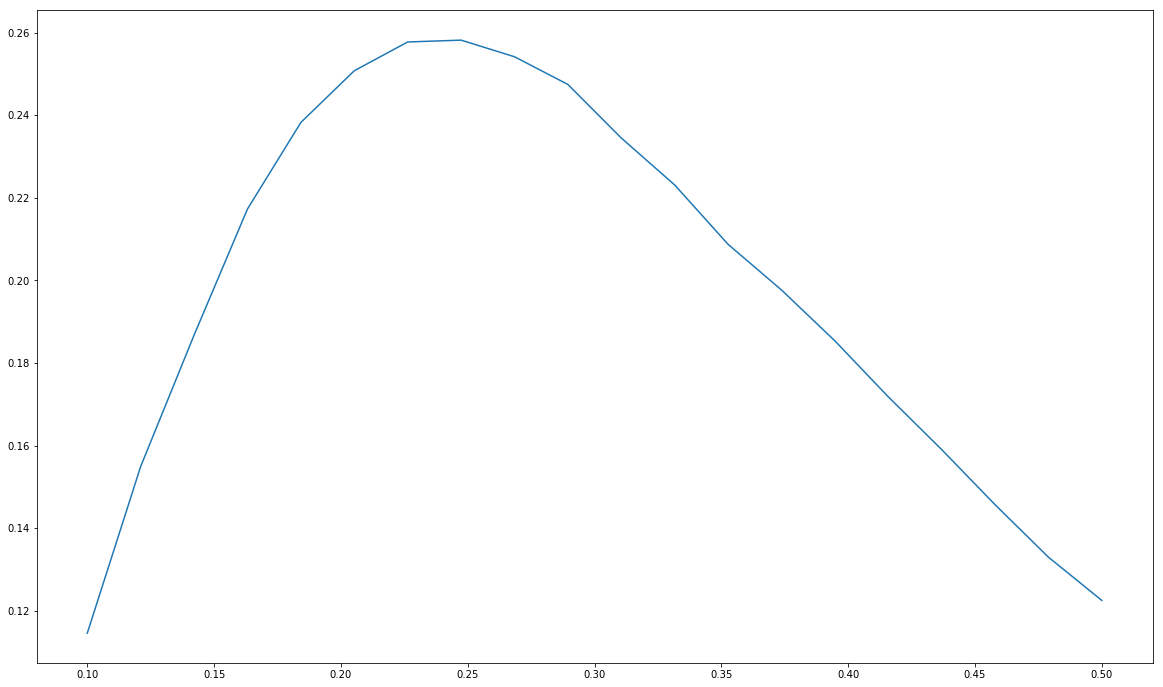

In [48]:
x_axis = np.linspace(0.1, 0.5, 20)
y_axis = []
for x in x_axis:
    y_ohe2 = (y_pred>x).astype(int)
    y = accuracy_score(y_val, y_ohe2)
    y_axis.append(y)

plt.figure(figsize=(20,12))
plt.plot(x_axis, y_axis)
plt.show()

We can see that the best accuracy is reached at 0.23 threshold but it's only 26%... We cannot do the confusion matrix as we are multilabel but here we can see that the result is not very good too. The good point is that we are sure there is no overfitting due to Oversampling or duplicate records. Nevertheless the result is not good too. One improvement we can do is to look at WaveNet model to extract features in a latent space and maybe the result will be the best as it uses the state of arts in term of model